<a href="https://colab.research.google.com/github/MAGPIEZ-CODE/MAGCalcium/blob/main/C_AnalisisCalciov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import required libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
from google.colab import files
from scipy import signal
from scipy.signal import detrend
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline

**2. Upload file**

In [ ]:
uploaded = files.upload()

Saving Results_AbPi1_1zone - With field_probenecidv3.xlsx to Results_AbPi1_1zone - With field_probenecidv3.xlsx


**4. Read the file**

In [ ]:
# Obtener el nombre del archivo subido
for filename in uploaded.keys():
    file_path = filename
# Leer el archivo Excel
df = pd.read_excel(file_path)
# Excluir la primera columna (identificador de fotograma)
df_sin_identificador = df.iloc[:, 1:]
# Identificar la primera columna vacía que separa ROIs y Fondo
columna_vacia = df_sin_identificador.columns[df_sin_identificador.isna().all()].tolist()

**5. Main calculation instructions**

In [ ]:
# Inicializar DataFrame para resultados
df_resultado = pd.DataFrame()

# Revisar si existe columna vacía
if columna_vacia:
    # Paso 1: Obtener el índice de la primera columna vacía y detectar columnas de ROI y fondo
    idx_vacio = df_sin_identificador.columns.get_loc(columna_vacia[0])
    columnas_rois = df_sin_identificador.columns[:idx_vacio]
    columnas_fondo = df_sin_identificador.columns[idx_vacio + 1:]

    # Guardar los ROIs originales en df_resultado al inicio
    for i, col in enumerate(columnas_rois):
        df_resultado[f'ROI({i+1})'] = df_sin_identificador[col]

    # Agregar columna en blanco antes de guardar el fondo
    df_resultado[' '] = None

    # Paso 2: Calcular el promedio de fondo para cada fotograma
    avg_fondo = df_sin_identificador[columnas_fondo].mean(axis=1)
    df_resultado['Avg_Fondo'] = avg_fondo

    # Agregar columna en blanco antes de los ROIs sin fondo
    df_resultado['  '] = None

    # Paso 3: Calcular ROIs sin fondo
    roi_sin_fondo = pd.DataFrame({
        f'ROI_sF({i+1})': df_sin_identificador[col] - avg_fondo for i, col in enumerate(columnas_rois)
    })
    df_resultado = pd.concat([df_resultado, roi_sin_fondo], axis=1)

    # Agregar columna en blanco antes de la envolvente
    df_resultado['   '] = None

    # Paso 4: Crear y suavizar línea de envolvente inferior para cada ROI
    envelope_lines = pd.DataFrame()
    detrended_rois = pd.DataFrame()
    for i, col in enumerate(roi_sin_fondo.columns):
        roi_signal = roi_sin_fondo[col]

        # Encontrar índices de mínimos locales
        min_indices = argrelextrema(roi_signal.values, np.less)[0]
        min_values = roi_signal.iloc[min_indices]

        # Verificar si hay suficientes puntos para interpolación
        if len(min_values) < 6:
            print(f"Not enough minima for ROI {i+1}. Skipping.")
            continue

        # Interpolación cúbica para crear la envolvente
        interpolation_func = interp1d(min_indices, min_values, kind='cubic', fill_value="extrapolate")
        envelope_line = interpolation_func(roi_signal.index)

        # Suavizar la línea de envolvente con la interpolación cúbica
        envelope_line_smooth = pd.Series(envelope_line).bfill().ffill()

        envelope_lines[f'Envelope_ROI({i+1})'] = envelope_line_smooth

        # Paso 5: Quitar la línea de tendencia usando la envolvente suavizada
        detrended_signal = roi_signal - envelope_line_smooth
        detrended_rois[f'Detrended_ROI_sF({i+1})'] = detrended_signal

    # Agregar resultados de la envolvente y los datos sin tendencia a df_resultado
    df_resultado = pd.concat([df_resultado, envelope_lines], axis=1)
    df_resultado['    '] = None
    df_resultado = pd.concat([df_resultado, detrended_rois], axis=1)

    # Agregar columna en blanco antes de ΔF/F0 sin fondo
    df_resultado['     '] = None

    # Paso 6: Calcular ΔF/F0 para cada ROI sin fondo (usando promedio de primeros 6 valores de ROI sin fondo)
    df_dff0_sin_fondo = pd.DataFrame()
    for i, col in enumerate(roi_sin_fondo.columns):
        roi_signal = roi_sin_fondo[col]
        F0 = roi_signal.iloc[:6].mean()
        df_dff0_sin_fondo[f'ROI_sF_DF/F0({i+1})'] = (roi_signal - F0) / F0
    df_resultado = pd.concat([df_resultado, df_dff0_sin_fondo], axis=1)

    # Agregar columna en blanco antes de ΔF/F0 sin tendencia de la envolvente
    df_resultado['      '] = None

    # Paso 7: Calcular ΔF/F0 para cada ROI sin tendencia de la envolvente
    df_dff0_sin_tendencia = pd.DataFrame()
    for i, col in enumerate(detrended_rois.columns):
        detrended_signal = detrended_rois[col]
        F0 = detrended_signal.iloc[:6].mean()
        df_dff0_sin_tendencia[f'Detrended_ROI_sF_DF/F0({i+1})'] = (detrended_signal - F0) / F0
    df_resultado = pd.concat([df_resultado, df_dff0_sin_tendencia], axis=1)

    # Agregar columna en blanco antes de los cálculos de actividad
    df_resultado['       '] = None

    # Paso 8: Calcular actividad desde ΔF/F0 sin tendencia
    activity_df = pd.DataFrame()
    for i, col in enumerate(df_dff0_sin_tendencia.columns):
        detrended_dff0_signal = df_dff0_sin_tendencia[col]
        std_f0 = detrended_dff0_signal.iloc[:6].std()
        activity_threshold = 3 * std_f0
        activity_df[f'Activity_Detrended_ROI({i+1})'] = (detrended_dff0_signal > activity_threshold).astype(int)
    df_resultado = pd.concat([df_resultado, activity_df], axis=1)

    # Paso 9: Actividad basada en los datos de ΔF/F0 sin fondo
    activity_sin_fondo = pd.DataFrame()
    for i, col in enumerate(df_dff0_sin_fondo.columns):
        dff0_signal = df_dff0_sin_fondo[col]
        std_f0 = dff0_signal.iloc[:6].std()
        activity_threshold = 3 * std_f0
        activity_sin_fondo[f'Activity_ROI_sF({i+1})'] = (dff0_signal > activity_threshold).astype(int)
    df_resultado = pd.concat([df_resultado, activity_sin_fondo], axis=1)

    # Paso 10: Calcular área bajo la curva de la envolvente inferior desde fotograma 6 hasta el final
    area_under_envelope = {}
    for i, col in enumerate(envelope_lines.columns):
        envelope_signal = envelope_lines[col].iloc[5:]  # Desde el fotograma 6 hasta el final
        area = np.trapz(envelope_signal, dx=1)  # Integración numérica con trapecios
        area_under_envelope[f'Area_Envelope_ROI({i+1})'] = area

        # Imprimir el área bajo la curva para cada ROI
        print(f"Área bajo la curva de la envolvente inferior para ROI {i+1}: {area}")

    # Agregar el resultado de las áreas calculadas a df_resultado como una fila al final
    df_resultado = pd.concat([df_resultado, pd.DataFrame([area_under_envelope])], ignore_index=True)

    # Guardar resultados en archivo Excel
    df_resultado.to_excel("output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx", index=False)

    print("All calculations completed and saved to 'output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx'.")

else:
    print("No empty column found to separate ROIs and background.")


Área bajo la curva de la envolvente inferior para ROI 1: 337484.2237770187
Área bajo la curva de la envolvente inferior para ROI 2: 351235.3528615704
Área bajo la curva de la envolvente inferior para ROI 3: 249621.19837191302
Área bajo la curva de la envolvente inferior para ROI 4: 559521.7081430163
Área bajo la curva de la envolvente inferior para ROI 5: 316794.1729163494
Área bajo la curva de la envolvente inferior para ROI 6: 367961.69952989364
Área bajo la curva de la envolvente inferior para ROI 7: 411260.45382843487
Área bajo la curva de la envolvente inferior para ROI 8: 334847.9565049799
Área bajo la curva de la envolvente inferior para ROI 9: 420303.26492255804
Área bajo la curva de la envolvente inferior para ROI 10: 346364.05352164916
Área bajo la curva de la envolvente inferior para ROI 11: 261844.09568114261
Área bajo la curva de la envolvente inferior para ROI 12: 524014.24539419886
Área bajo la curva de la envolvente inferior para ROI 13: 246704.78402997044
Área bajo la 

**6. Plot the original ROI data without any processing**

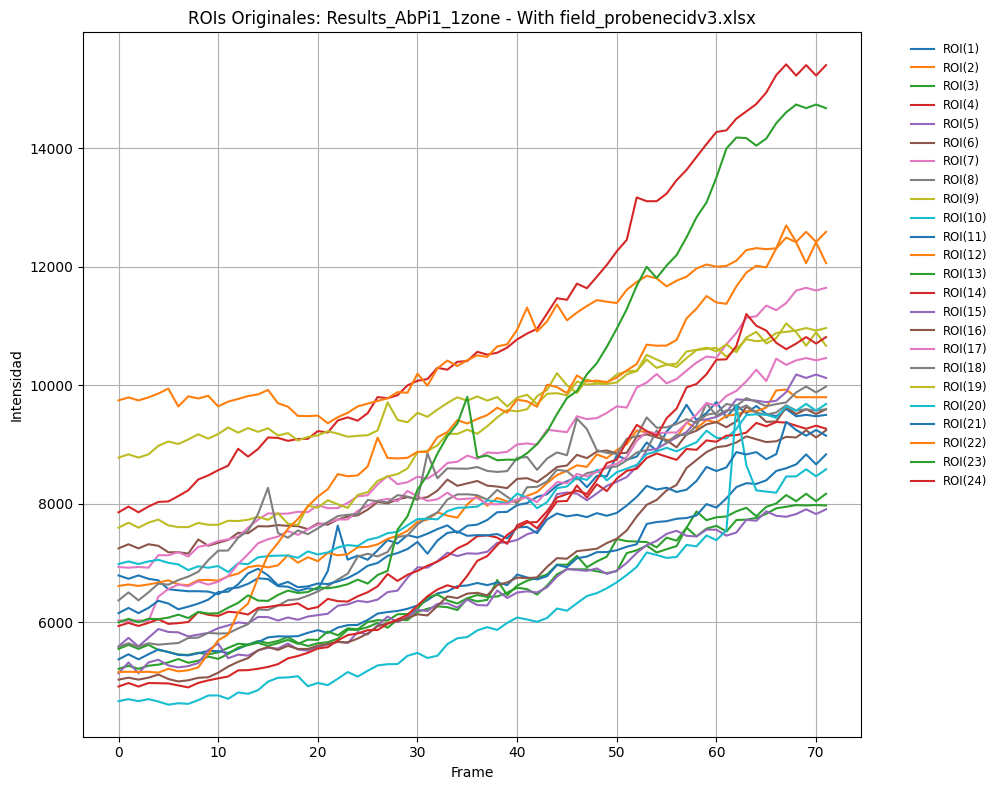

In [ ]:
# Configuración de la gráfica
plt.figure(figsize=(12, 8))

# Graficar cada ROI original
for i, col in enumerate([col for col in df_resultado.columns if col.startswith("ROI(")]):
    plt.plot(df_resultado.index, df_resultado[col], label=col)

# Ajustes de la gráfica
plt.title(f"ROIs Originales: {filename}")
plt.xlabel("Frame")
plt.ylabel("Intensidad")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Mostrar la gráfica
plt.show()


**7. Plot the ROI data with background subtracted**

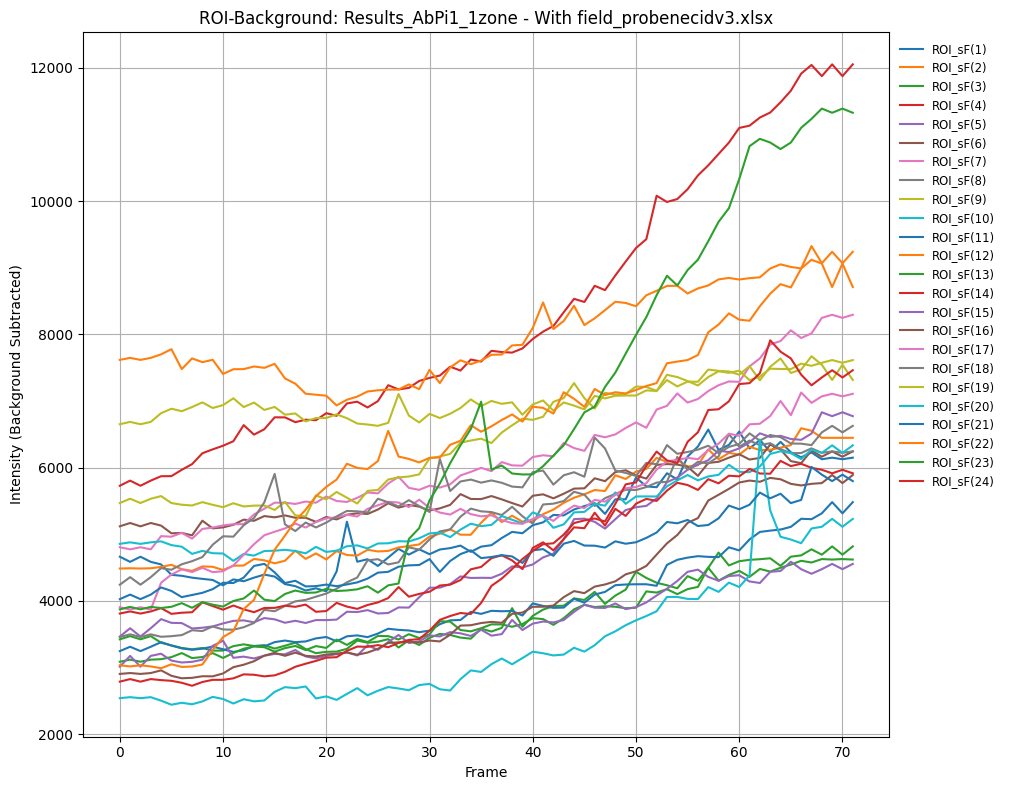

In [ ]:
# Plot the ROI data with background subtracted
plt.figure(figsize=(12, 8))
for i in range(len(columnas_rois)):
    plt.plot(df_resultado.index, df_resultado[f'ROI_sF({i+1})'], label=f'ROI_sF({i+1})')

# Place the legend outside the plot area
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small', frameon=False)
plt.title(f"ROI-Background: {filename}")
plt.xlabel("Frame")
plt.ylabel("Intensity (Background Subtracted)")
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

**8. Plot of Originals ROI without background and with lower envelope**

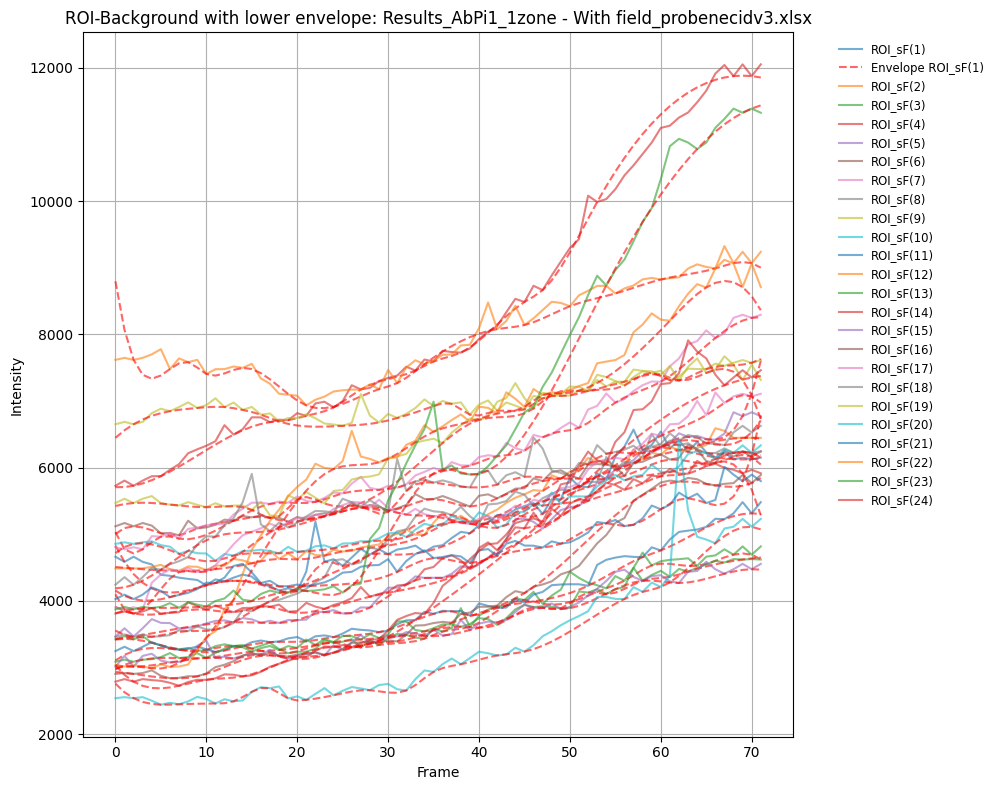

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Iterar sobre cada ROI sin fondo y su envolvente para graficarlos
for i, col in enumerate(roi_sin_fondo.columns):
    # Graficar cada ROI sin fondo
    plt.plot(roi_sin_fondo.index, roi_sin_fondo[col], label=f'ROI_sF({i+1})', alpha=0.6)

    # Graficar la línea de envolvente inferior para cada ROI
    plt.plot(envelope_lines.index, envelope_lines[f'Envelope_ROI({i+1})'], linestyle='--', color='red',
             label=f'Envelope ROI_sF({i+1})' if i == 0 else "", alpha=0.6)

# Configuración de la gráfica
plt.title(f"ROI-Background with lower envelope: {filename}")
plt.xlabel("Frame")
plt.ylabel("Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Mostrar la gráfica
plt.show()


**9. Polt of Originals ROI without background and without lower envelope trend**

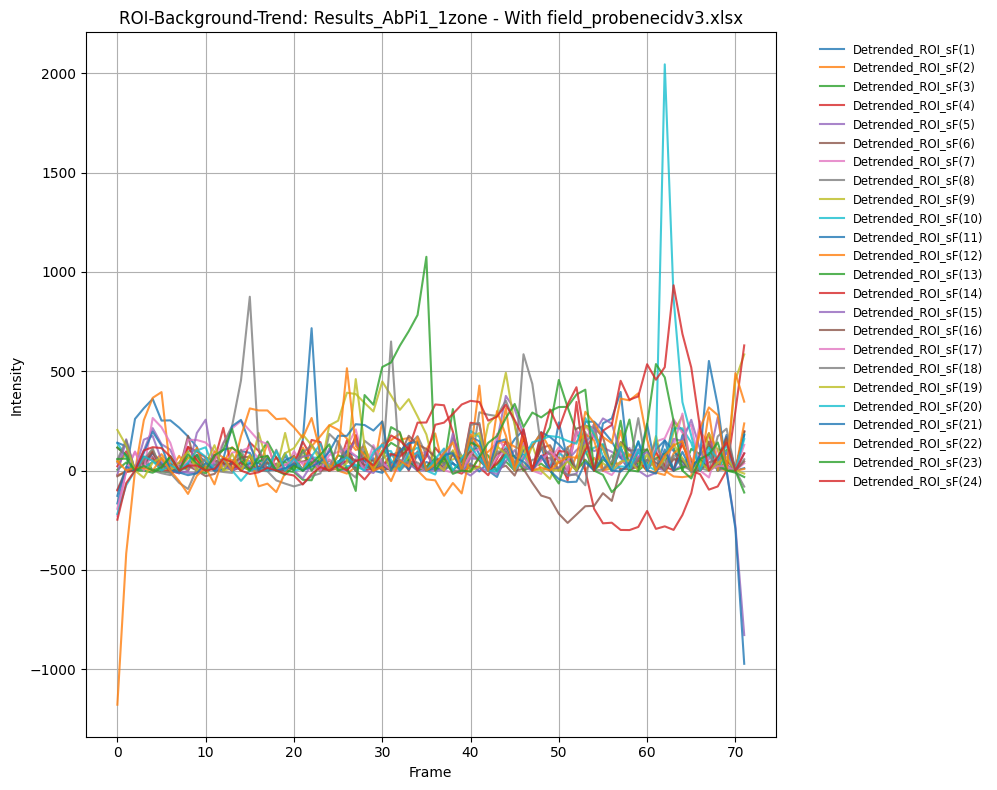

In [ ]:
# Crear una figura para la gráfica
plt.figure(figsize=(12, 8))

# Filtrar y graficar solo las columnas que empiezan exactamente con "Detrended_ROI_sF(" y no contienen "DF/F0"
for col in df_resultado.columns:
    if col.startswith('Detrended_ROI_sF(') and "DF/F0" not in col:
        plt.plot(df_resultado.index, df_resultado[col], label=col, alpha=0.8)

# Configurar la gráfica
plt.title(f"ROI-Background-Trend: {filename}")
plt.xlabel("Frame")
plt.ylabel("Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Mostrar la gráfica
plt.show()

**10. Plot of ΔF/F0 of Original ROI without background**

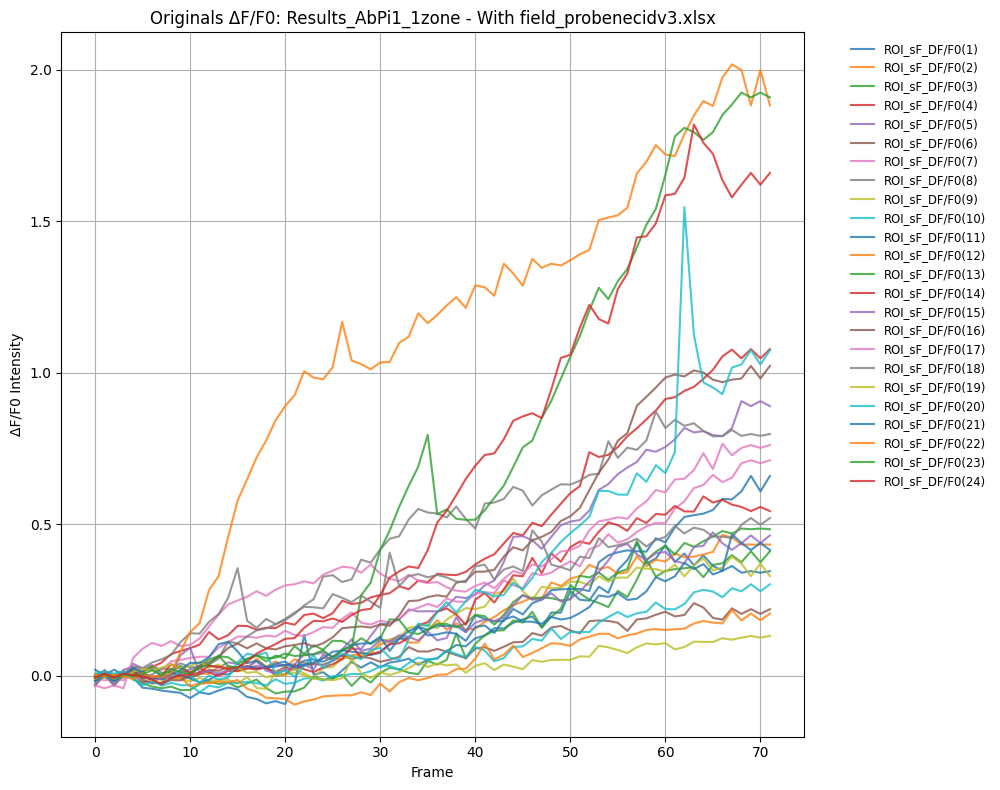

In [ ]:
# Crear una figura para la gráfica de ROI_sF_DF/F0
plt.figure(figsize=(12, 8))

# Filtrar y graficar solo las columnas que contienen "ROI_sF_DF/F0" en su nombre
for col in df_resultado.columns:
    if "ROI_sF_DF/F0" in col and "Detrended" not in col:
        plt.plot(df_resultado.index, df_resultado[col], label=col, alpha=0.8)

# Configuración de la gráfica
plt.title(f"Originals ΔF/F0: {filename}")
plt.xlabel("Frame")
plt.ylabel("ΔF/F0 Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Mostrar la gráfica
plt.show()

**11. Plot of ΔF/F0 without background and without trend**

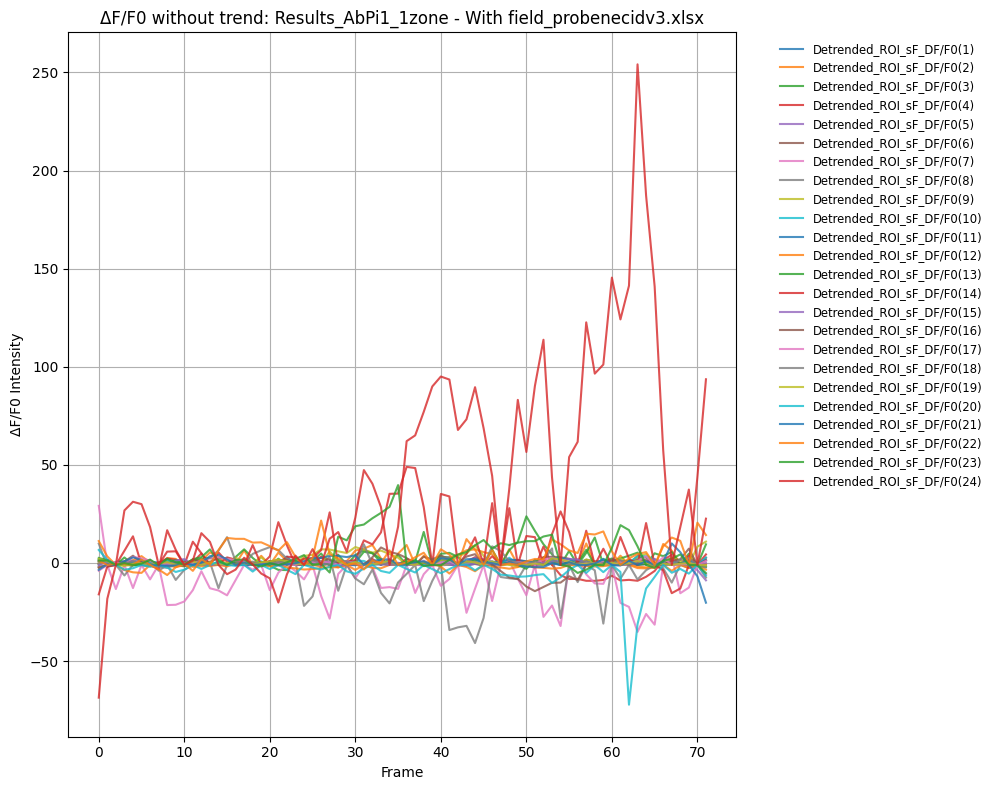

In [ ]:
# Crear una figura para la gráfica de Detrended_ROI_sF_DF/F0
plt.figure(figsize=(12, 8))

# Filtrar y graficar solo las columnas que contienen "Detrended_ROI_sF_DF/F0" en su nombre
for col in df_resultado.columns:
    if "Detrended_ROI_sF_DF/F0" in col:
        plt.plot(df_resultado.index, df_resultado[col], label=col, alpha=0.8)

# Configuración de la gráfica
plt.title(f"ΔF/F0 without trend: {filename}")
plt.xlabel("Frame")
plt.ylabel("ΔF/F0 Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Mostrar la gráfica
plt.show()

**12. Heatmap of DF/F0 of Original ROI without background**

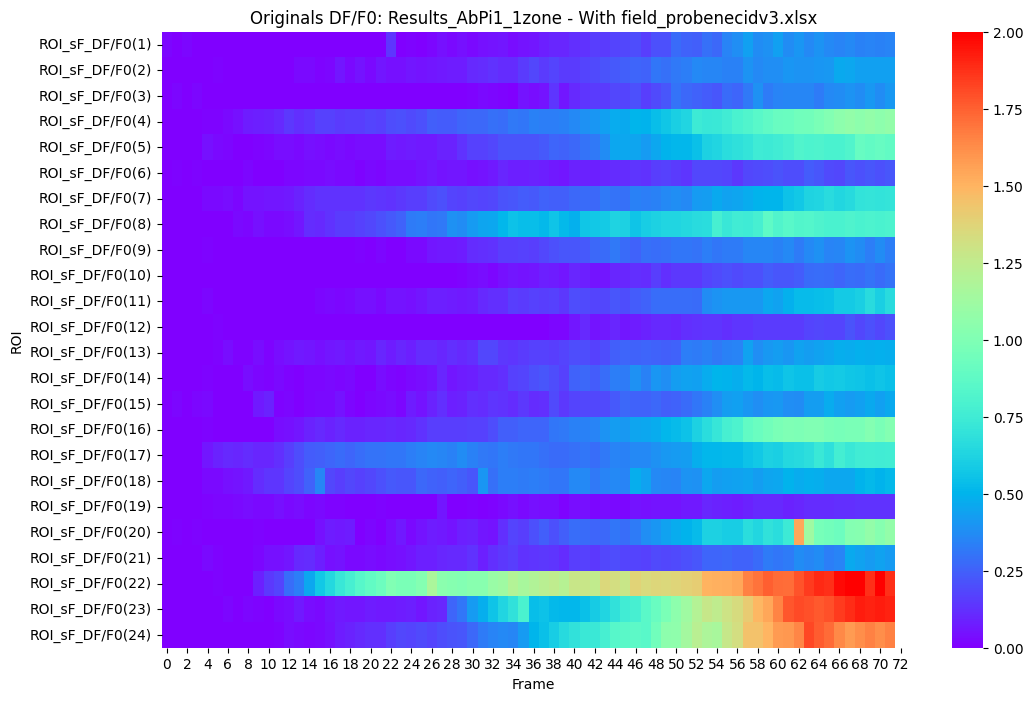

In [ ]:
# Filtrar solo las columnas que contienen "ROI_sF_DF/F0" (sin tendencia de fondo)
roi_sf_dff0_data = df_resultado[[col for col in df_resultado.columns if "ROI_sF_DF/F0" in col and "Detrended" not in col]]

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(roi_sf_dff0_data.T, cmap="rainbow", cbar=True, annot=False, vmin=0, vmax=2)

# Configuración de la gráfica
plt.title(f"Originals DF/F0: {filename}")
plt.xlabel("Frame")
plt.ylabel("ROI")
plt.show()

**13. Heatmap of DF/F0 of Original ROI without background and without trend**

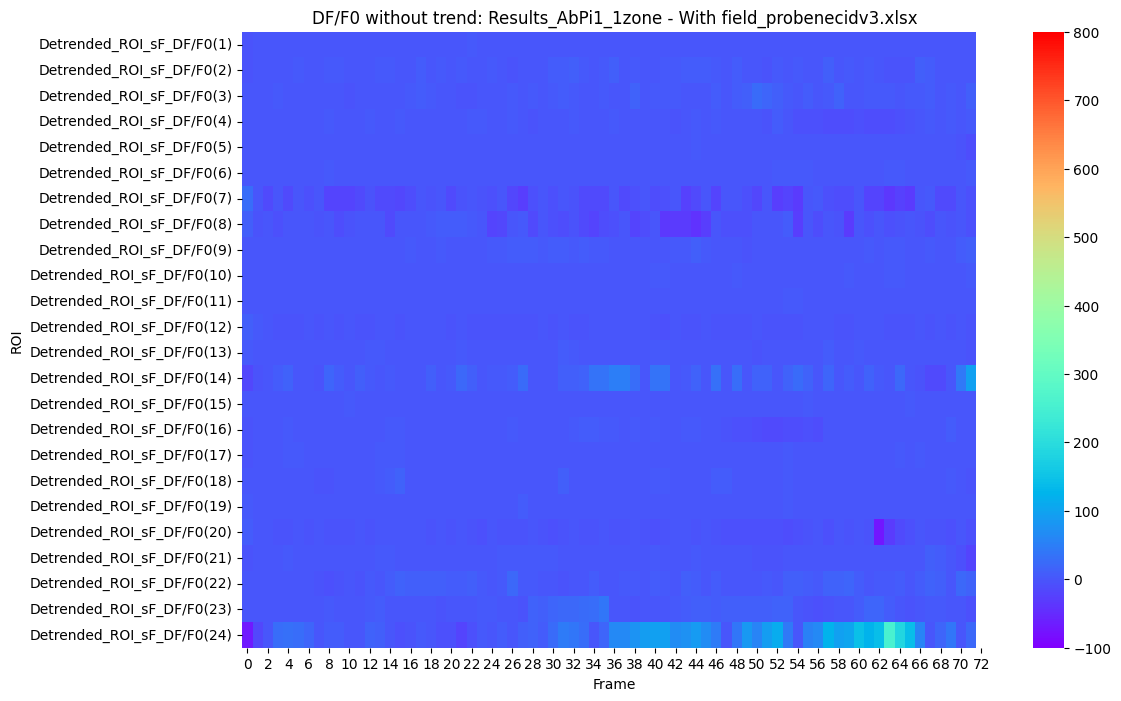

In [ ]:
# Filtrar solo las columnas que contienen "Detrended_ROI_sF_DF/F0" (sin tendencia de fondo y envolvente)
detrended_roi_sf_dff0_data = df_resultado[[col for col in df_resultado.columns if "Detrended_ROI_sF_DF/F0" in col]]

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(detrended_roi_sf_dff0_data.T, cmap="rainbow", cbar=True, annot=False, vmin=-100, vmax=800)

# Configuración de la gráfica
plt.title(f"DF/F0 without trend: {filename}")
plt.xlabel("Frame")
plt.ylabel("ROI")
plt.show()

**14. Heatmap of Activity of Original ROI without background**

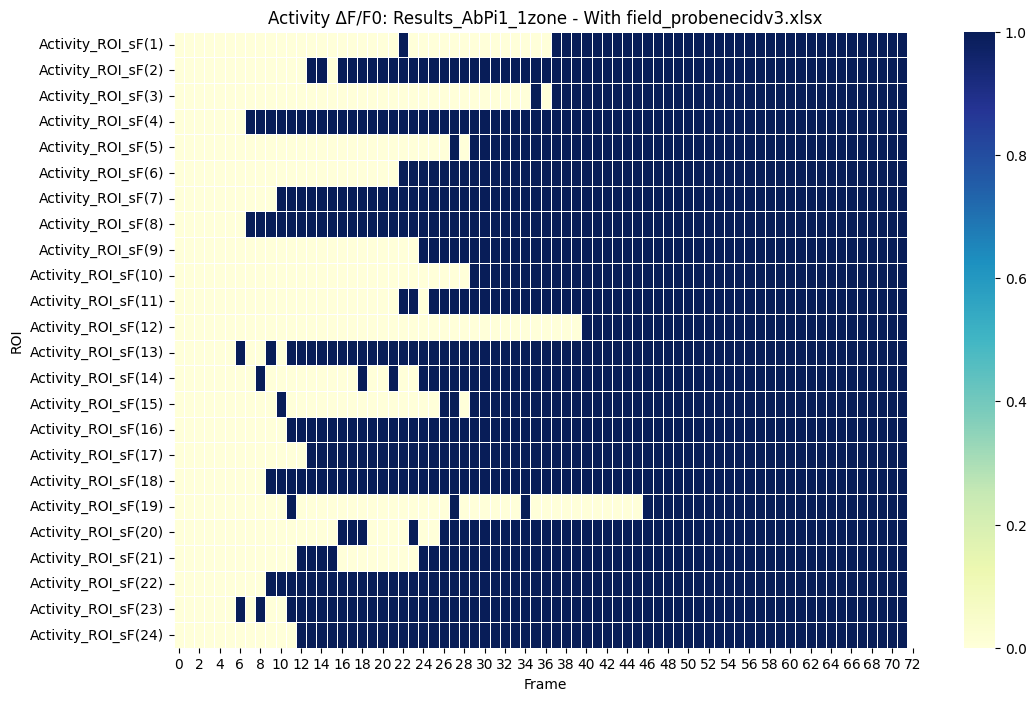

In [ ]:
# Filtrar solo las columnas que contienen "Activity_ROI_sF" (actividad sin tendencia de fondo)
activity_roi_sf_data = df_resultado[[col for col in df_resultado.columns if "Activity_ROI_sF" in col]]

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(activity_roi_sf_data.T, cmap="YlGnBu", cbar=True, annot=False, linewidths=.5)

# Configuración de la gráfica
plt.title(f"Activity ΔF/F0: {filename}")
plt.xlabel("Frame")
plt.ylabel("ROI")
plt.show()

**15. Heatmap of Activity of Original ROI without background and without trend**

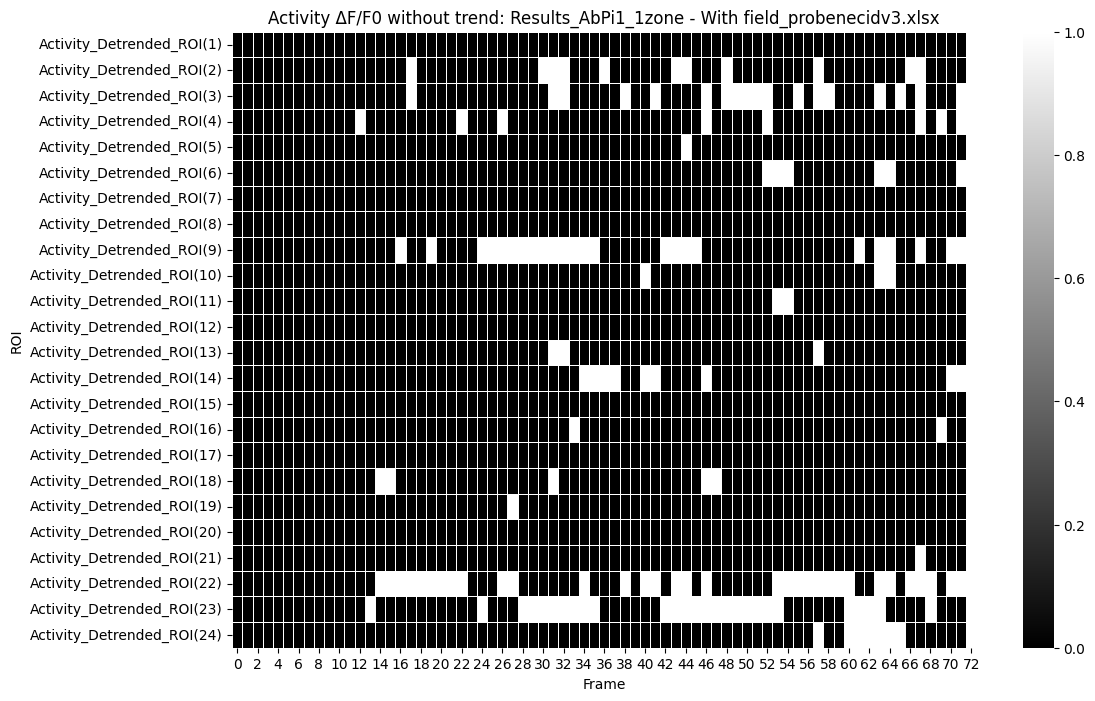

In [ ]:
# Filtrar solo las columnas que contienen "Activity_Detrended_ROI" (actividad sin fondo y sin envolvente)
activity_detrended_roi_data = df_resultado[[col for col in df_resultado.columns if "Activity_Detrended_ROI" in col]]

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(activity_detrended_roi_data.T, cmap="gray", cbar=True, annot=False, linewidths=.5)

# Configuración de la gráfica
plt.title(f"Activity ΔF/F0 without trend: {filename}")
plt.xlabel("Frame")
plt.ylabel("ROI")
plt.show()

**16. Save the generated file**

In [ ]:
# Guardar el archivo modificado en Excel
df_resultado.to_excel('archivo_procesado_paso2.xlsx', index=False)
print("El archivo modificado ha sido guardado como 'archivo_procesado_paso2.xlsx'")

El archivo modificado ha sido guardado como 'archivo_procesado_paso2.xlsx'


In [ ]:
# Descargar el archivo en tu computadora
files.download('archivo_procesado_paso2.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>